STEP 1: LOADING DATA AND ENGINEERING TARGET/FEATURES
Target and features created successfully.
STEP 2: DEFINING ABLATION FEATURE SETS
STEP 3: DEFINING REGRESSION ABLATION EXPERIMENT
STEP 4: RUNNING ABLATION MODELS...

--- Testing Model: Test 1: Raw Features Only ---
   Numeric Features (14): Danceability, Energy, Loudness, Speechiness, Acousticness, Instrumentalness, Valence, Points (Total), song_year, song_month, song_season, rank_slope, artist_count, superstar
   Categorical Features (0): None
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2183
[LightGBM] [Info] Number of data points in the train set: 7752, number of used features: 14
[LightGBM] [Info] Start training from score 1.626840
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
   Completed in: 6.

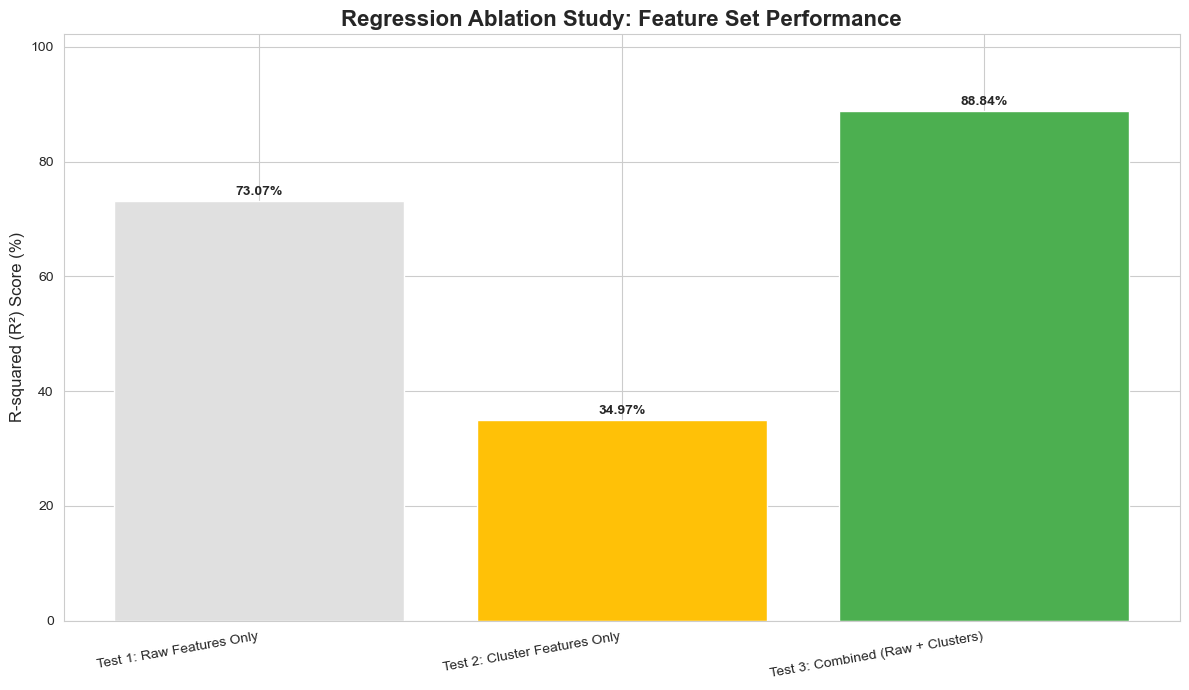

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error

from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report

from sklearn.ensemble import GradientBoostingClassifier

# Suppress warnings
warnings.filterwarnings('ignore')

# Set visualization styles
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

def run_regression_ablation_study():
    """
    Runs a granular ablation study for the Regression model.
    Measures the R-squared (R²) of:
    1. Raw Features Only (Baseline)
    2. Cluster Features Only
    3. Combined (Raw + Clusters)
    
    This script uses the correct ColumnTransformer preprocessing from regression_v6.ipynb.
    """
    
    # --- 1. Load Data and Engineer Features/Target (From regression_v6.ipynb) ---
    print("STEP 1: LOADING DATA AND ENGINEERING TARGET/FEATURES")
    try:
        df = pd.read_csv('Spotify_Dataset_V3_All_Clusters_v2.csv')
    except FileNotFoundError:
        print("Error: 'Spotify_Dataset_V3_All_Clusters_v2.csv' not found.")
        return

    df['Date_parsed'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    df = df.dropna(subset=['Date_parsed'])
    df['year_week'] = df['Date_parsed'].dt.isocalendar().year.astype(str) + '-W' + \
                      df['Date_parsed'].dt.isocalendar().week.astype(str)
    
    agg = df.groupby('id').agg(
        weeks_in_top200=('year_week', 'nunique'),
        first_chart_date=('Date_parsed', 'min'),
        initial_rank=('Rank', 'min'),
        max_rank=('Rank', 'max')
    ).reset_index()

    # Engineer raw features
    agg['song_year'] = agg['first_chart_date'].dt.year
    agg['song_month'] = agg['first_chart_date'].dt.month
    agg['song_season'] = agg['song_month'] % 12 // 3 + 1
    agg['rank_slope'] = (agg['max_rank'] - agg['initial_rank']) / agg['weeks_in_top200']
    agg['rank_slope'] = agg['rank_slope'].replace([np.inf, -np.inf], 0).fillna(0)

    # Merge audio features and cluster labels
    meta_cols = ['Sonic_Cluster_Label', 'Artist_Tier_Label', 'Temporal_Cluster_Name',
                 'Performance_Cluster_Name', 'Collab_Cluster_Name', 'Geo_Cluster_Name', 
                 'Evo_Cluster_Name']
    numeric_cols = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 
                    'Acousticness', 'Instrumentalness', 'Valence', 'Points (Total)']
    
    data_sample = df.groupby('id').first().reset_index()
    agg = agg.merge(data_sample[['id'] + meta_cols + numeric_cols + ['Artists']], on='id')
    
    agg['artist_count'] = agg['Artists'].fillna('').apply(lambda x: len(str(x).split(',')))
    agg['superstar'] = (agg['Artist_Tier_Label'] == 'Superstars').astype(int)

    # --- Define Target (Y) ---
    agg = agg.dropna(subset=['weeks_in_top200'])
    y = np.log1p(agg['weeks_in_top200']) # Target is weeks_log
    
    print("Target and features created successfully.")

    # --- 2. Define Feature Sets for Ablation ---
    print("STEP 2: DEFINING ABLATION FEATURE SETS")
    
    features_raw_numeric = numeric_cols + [
        'song_year', 'song_month', 'song_season', 'rank_slope', 'artist_count', 'superstar'
    ]
    
    features_cluster_categorical = meta_cols

    # --- 3. Define Ablation Experiment ---
    print("STEP 3: DEFINING REGRESSION ABLATION EXPERIMENT")

    ablation_plan = {
        "Test 1: Raw Features Only": {
            'num': features_raw_numeric,
            'cat': []
        },
        "Test 2: Cluster Features Only": {
            'num': [],
            'cat': features_cluster_categorical
        },
        "Test 3: Combined (Raw + Clusters)": {
            'num': features_raw_numeric,
            'cat': features_cluster_categorical
        }
    }
    
    ablation_results = []
    
    # Use the Temporal Split from your notebook
    dates = agg['first_chart_date']
    unique_dates = np.array(sorted(agg['first_chart_date'].unique()))
    cutoff_index = int(len(unique_dates) * 0.8)
    cutoff_date = unique_dates[cutoff_index]
    
    train_mask = (dates <= cutoff_date)
    test_mask = (dates > cutoff_date)
    
    X = agg[features_raw_numeric + features_cluster_categorical]

    # --- 4. Run Experiment Loop ---
    print("STEP 4: RUNNING ABLATION MODELS...")

    for set_name, features in ablation_plan.items():
        print(f"\n--- Testing Model: {set_name} ---")
        
        num_feats = features['num']
        cat_feats = features['cat']
        
        print(f"   Numeric Features ({len(num_feats)}): {', '.join(num_feats) if num_feats else 'None'}")
        print(f"   Categorical Features ({len(cat_feats)}): {', '.join(cat_feats) if cat_feats else 'None'}")

        # 4a. Build Preprocessing Pipeline
        transformers = []
        if num_feats:
            numeric_transformer = Pipeline(steps=[
                ('imp', SimpleImputer(strategy='median')),
                ('sc', StandardScaler())
            ])
            transformers.append(('num', numeric_transformer, num_feats))
            
        if cat_feats:
            categorical_transformer = Pipeline(steps=[
                ('imp', SimpleImputer(strategy='most_frequent')),
                ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ])
            transformers.append(('cat', categorical_transformer, cat_feats))
        
        preprocessor = ColumnTransformer(transformers=transformers)

        # 4b. Define "Judge" Model
        model = LGBMRegressor(
            random_state=42,
            learning_rate=0.1,
            max_depth=12,
            n_estimators=300,
            num_leaves=31,
            subsample=0.8
        )
        
        # 4c. Create Full Pipeline
        full_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        # 4d. Split, Train, and Evaluate
        X_train, X_test = X[train_mask], X[test_mask]
        y_train, y_test = y[train_mask], y[test_mask]
        
        start_time = time.time()
        full_pipeline.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        y_pred = full_pipeline.predict(X_test)
        
        r2 = r2_score(y_test, y_pred) * 100
        
        # --- THIS IS THE FIX ---
        # Calculate MSE first
        mse = mean_squared_error(y_test, y_pred)
        # Calculate RMSE by taking the square root
        rmse = np.sqrt(mse)
        # --- END OF FIX ---
        
        print(f"   Completed in: {train_time:.2f}s")
        print(f"   Test R-squared (R²): {r2:.2f}%")
        print(f"   Test RMSE: {rmse:.3f}")
        
        ablation_results.append({
            'Model': set_name,
            'R-Squared': r2,
            'RMSE': rmse,
            'Num_Features': len(num_feats) + len(cat_feats)
        })

    # --- 5. Report Final Results ---
    print("\n\n--- REGRESSION ABLATION STUDY RESULTS ---")
    
    results_df = pd.DataFrame(ablation_results).sort_values('R-Squared', ascending=False)
    print(results_df.to_string(index=False, float_format="%.2f"))

    # Plot the results
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 7))
    # Re-order for logical flow
    results_df = results_df.reindex(results_df['Model'].map({
        "Test 1: Raw Features Only": 0,
        "Test 2: Cluster Features Only": 1,
        "Test 3: Combined (Raw + Clusters)": 2
    }).sort_values().index)
    
    bars = plt.bar(results_df['Model'], results_df['R-Squared'], 
                   color=['#E0E0E0', '#FFC107', '#4CAF50'])
    plt.ylabel('R-squared (R²) Score (%)', fontsize=12)
    plt.title('Regression Ablation Study: Feature Set Performance', fontsize=16, fontweight='bold')
    plt.ylim(0, max(results_df['R-Squared']) * 1.15)
    plt.xticks(rotation=10, ha='right')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{height:.2f}%',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')
                 
    plt.tight_layout()
    plt.savefig('regression_ablation_study_results.png', dpi=300)
    print("\nSaved chart to 'regression_ablation_study_results.png'")
    plt.show()

# Run the study
if __name__ == "__main__":
    run_regression_ablation_study()

STEP 1: LOADING DATA AND CREATING BINARY TARGET VARIABLE
Binary target variable created successfully.
STEP 2: CREATING FEATURE MASTER TABLE
Feature master table created with 9161 unique songs.
STEP 3: DEFINING BINARY ABLATION EXPERIMENT
STEP 4: RUNNING ABLATION MODELS...

--- Testing Model: Test 1: Raw Audio Only (Baseline) ---
   Features (7): Danceability, Energy, Loudness, Speechiness, Acousticness, Instrumentalness, Valence
   Completed in: 0.36s
   Test F1-Score (Sustained Hit): 63.16%

--- Testing Model: Test 2: Raw Audio + Performance_Cluster ---
   Features (8): Danceability, Energy, Loudness, Speechiness, Acousticness, Instrumentalness, Valence, Performance_Cluster
   Completed in: 0.17s
   Test F1-Score (Sustained Hit): 76.92%

--- Testing Model: Test 3: Raw Audio + All Clusters (Full Model) ---
   Features (14): Acousticness, Artist_Tier, Collab_Cluster_ID, Danceability, Energy, Evo_Cluster_ID, Geo_Cluster_ID, Instrumentalness, Loudness, Performance_Cluster, Sonic_Cluster, S

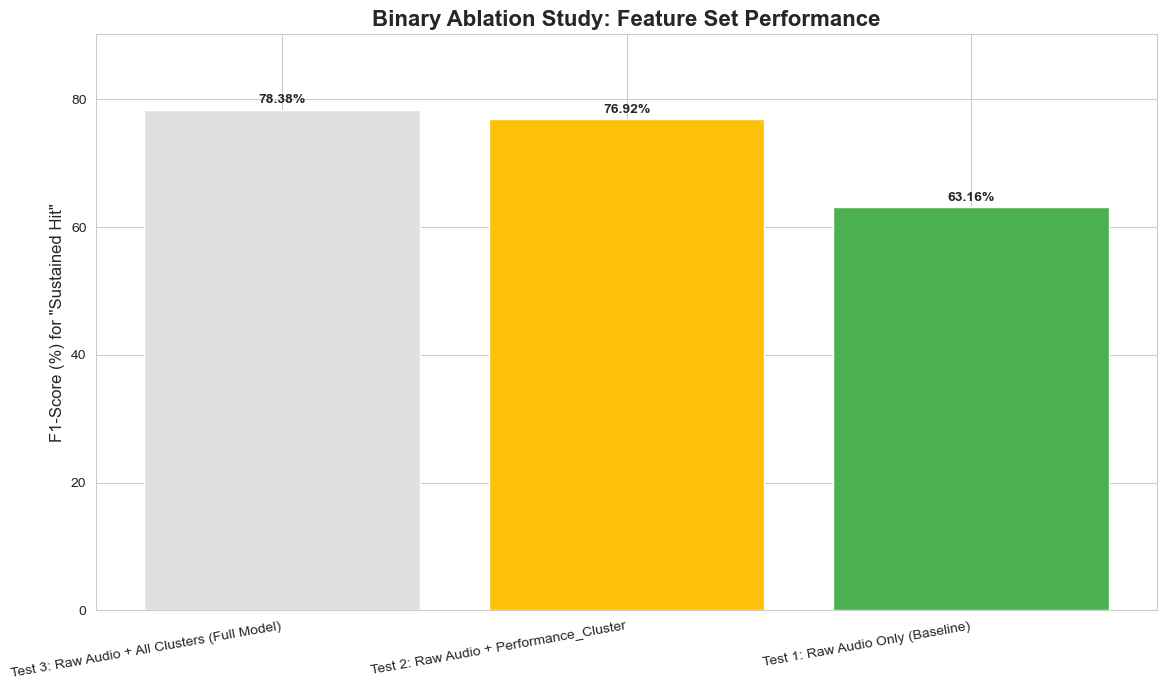

In [2]:


# Suppress warnings
warnings.filterwarnings('ignore')

# Set visualization styles
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

def run_binary_ablation_study():
    """
    Runs a granular ablation study for the Binary Classification model.
    Measures the specific impact of:
    1. Raw audio features (Baseline)
    2. Baseline + The "Golden" Performance_Cluster
    3. Baseline + All Clusters (The Full Model)
    """
    
    # --- 1. Load Data and Define Target (From Binary_Classification.ipynb) ---
    print("STEP 1: LOADING DATA AND CREATING BINARY TARGET VARIABLE")
    try:
        df = pd.read_csv('Spotify_Dataset_V3_All_Clusters_v2.csv')
    except FileNotFoundError:
        print("Error: 'Spotify_Dataset_V3_All_Clusters_v2.csv' not found.")
        return

    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    
    # Aggregate to song level to count weeks
    song_weeks = df.groupby('id').agg({'Date': 'count'}).reset_index()
    song_weeks.columns = ['id', 'Weeks_In_Charts']

    # Your BINARY target categorization function (8+ weeks)
    def categorize_success_binary(weeks):
        if weeks >= 8:
            return 1  # Sustained Hit
        else:
            return 0  # Flop
    
    song_weeks['Success_Category'] = song_weeks['Weeks_In_Charts'].apply(categorize_success_binary)
    print("Binary target variable created successfully.")

    
    # --- 2. Create Feature Master Table ---
    print("STEP 2: CREATING FEATURE MASTER TABLE")
    song_features = df.sort_values('Date').groupby('id').first().reset_index()

    # Define the 3 feature sets for our experiment
    features_raw_audio = [
        'Danceability', 'Energy', 'Loudness', 'Speechiness', 
        'Acousticness', 'Instrumentalness', 'Valence'
    ]
    
    features_all_clusters = [
        'Sonic_Cluster', 'Artist_Tier', 'Temporal_Cluster',
        'Performance_Cluster', 'Geo_Cluster_ID', 'Collab_Cluster_ID', 'Evo_Cluster_ID'
    ]
    
    features_test_1 = features_raw_audio
    features_test_2 = features_raw_audio + ['Performance_Cluster']
    features_test_3 = sorted(list(set(features_raw_audio + features_all_clusters)))
    
    # Create the final dataset for modeling
    all_features_needed = sorted(list(set(features_test_1 + features_test_2 + features_test_3)))
    features_to_keep = ['id'] + all_features_needed
    
    song_features_selected = song_features[features_to_keep]
    
    final_data = song_features_selected.merge(
        song_weeks[['id', 'Success_Category']], 
        on='id', 
        how='inner'
    )
    final_data = final_data.dropna(subset=['Success_Category'] + all_features_needed)
    print(f"Feature master table created with {len(final_data)} unique songs.")

    
    # --- 3. Define Ablation Experiment ---
    print("STEP 3: DEFINING BINARY ABLATION EXPERIMENT")
    
    feature_sets_to_test = {
        "Test 1: Raw Audio Only (Baseline)": features_test_1,
        "Test 2: Raw Audio + Performance_Cluster": features_test_2,
        "Test 3: Raw Audio + All Clusters (Full Model)": features_test_3
    }
    
    # Get Target Variable (y) - no LabelEncoder needed as it's already 0/1
    y = final_data['Success_Category']
    
    ablation_results = []

    
    # --- 4. Run Experiment Loop ---
    print("STEP 4: RUNNING ABLATION MODELS...")
    
    for set_name, set_features in feature_sets_to_test.items():
        print(f"\n--- Testing Model: {set_name} ---")
        print(f"   Features ({len(set_features)}): {', '.join(set_features)}")
        
        X = final_data[set_features]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, 
            test_size=0.2, 
            random_state=42,
            stratify=y
        )
        
        # Define "Judge" Model (XGBClassifier from your notebook)
        model = XGBClassifier(
            n_estimators=100,
            max_depth=10,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            eval_metric='logloss',
            use_label_encoder=False
        )
        
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        y_pred = model.predict(X_test)
        
        # Use F1-Score for the positive class (1 = Sustained Hit)
        f1 = f1_score(y_test, y_pred, average='binary') * 100
        acc = accuracy_score(y_test, y_pred) * 100
        
        print(f"   Completed in: {train_time:.2f}s")
        print(f"   Test F1-Score (Sustained Hit): {f1:.2f}%")
        
        ablation_results.append({
            'Model': set_name,
            'F1-Score': f1,
            'Accuracy': acc,
            'Num_Features': len(set_features)
        })

        
    # --- 5. Report Final Results ---
    print("\n\n--- BINARY CLASSIFICATION ABLATION STUDY RESULTS ---")
    
    results_df = pd.DataFrame(ablation_results).sort_values('F1-Score', ascending=False)
    print(results_df.to_string(index=False, float_format="%.2f"))

    # Plot the results
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 7))
    results_df = results_df.reindex([2, 1, 0]) # Re-order for logical flow
    
    bars = plt.bar(results_df['Model'], results_df['F1-Score'], 
                   color=['#E0E0E0', '#FFC107', '#4CAF50'])
    plt.ylabel('F1-Score (%) for "Sustained Hit"', fontsize=12)
    plt.title('Binary Ablation Study: Feature Set Performance', fontsize=16, fontweight='bold')
    plt.ylim(0, max(results_df['F1-Score']) * 1.15)
    plt.xticks(rotation=10, ha='right')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{height:.2f}%',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')
                 
    plt.tight_layout()
    plt.savefig('binary_ablation_study_results.png', dpi=300)
    print("\nSaved chart to 'binary_ablation_study_results.png'")
    plt.show()

# Run the study
if __name__ == "__main__":
    run_binary_ablation_study()

STEP 1: LOADING DATA AND CREATING 3-CLASS TARGET VARIABLE
Target variable created successfully.
STEP 2: CREATING FEATURE MASTER TABLE
Feature master table created with 9161 unique songs.
STEP 3: DEFINING GRANULAR ABLATION EXPERIMENT
STEP 4: RUNNING ABLATION MODELS...

--- Testing Model: Test 1: Raw Audio Only (Baseline) ---
   Features (7): Danceability, Energy, Loudness, Speechiness, Acousticness, Instrumentalness, Valence
   Completed in: 6.54s
   Test F1-Score: 43.57%

--- Testing Model: Test 2: Raw Audio + Performance_Cluster ---
   Features (8): Danceability, Energy, Loudness, Speechiness, Acousticness, Instrumentalness, Valence, Performance_Cluster
   Completed in: 5.91s
   Test F1-Score: 55.18%

--- Testing Model: Test 3: Raw Audio + All Clusters (Full Model) ---
   Features (14): Acousticness, Artist_Tier, Collab_Cluster_ID, Danceability, Energy, Evo_Cluster_ID, Geo_Cluster_ID, Instrumentalness, Loudness, Performance_Cluster, Sonic_Cluster, Speechiness, Temporal_Cluster, Valenc

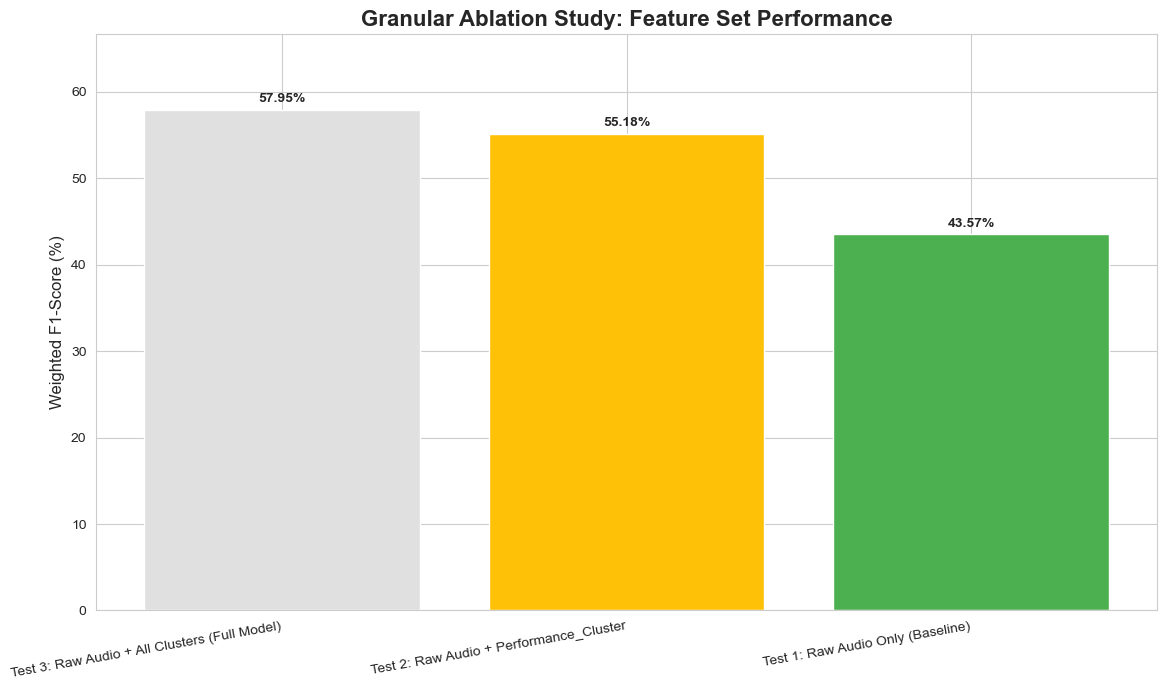


--- ANALYSIS OF RESULTS ---
Test 1 (Baseline) F1:      43.57%
Test 2 (Baseline + Golden) F1: 55.18%
Test 3 (Full Model) F1:        57.95%
---------------------------------
Performance Lift from 'Performance_Cluster': +11.62 percentage points
Performance Lift from *all other* clusters: +2.77 percentage points

CONCLUSION:
This test proves that your 'Performance_Cluster' is the single most valuable
feature, providing a massive 11.62-point lift on its own.
The remaining 6 clusters provide an additional 2.77-point lift,
confirming their value in the final, combined model.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, accuracy_score

# Suppress warnings
warnings.filterwarnings('ignore')

# Set visualization styles
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

def run_granular_ablation_study():
    """
    Runs a granular ablation study to measure the specific impact of:
    1. Raw audio features (Baseline)
    2. Baseline + The "Golden" Performance_Cluster
    3. Baseline + All Clusters (The Full Model)
    """
    
    # --- 1. Load Data and Define Target (From your notebook) ---
    print("STEP 1: LOADING DATA AND CREATING 3-CLASS TARGET VARIABLE")
    try:
        df = pd.read_csv('Spotify_Dataset_V3_All_Clusters_v2.csv')
    except FileNotFoundError:
        print("Error: 'Spotify_Dataset_V3_All_Clusters_v2.csv' not found.")
        print("Please make sure the file is in the same directory.")
        return

    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    
    # Aggregate to song level to count weeks
    song_weeks = df.groupby('id').agg({'Date': 'count'}).reset_index()
    song_weeks.columns = ['id', 'Weeks_In_Charts']

    # Your 3-class target categorization function
    def categorize_success_3class(weeks):
        if weeks < 2:
            return 'Flop'
        elif weeks < 20:
            return 'Moderate Hit'
        else:
            return 'Long-Term Hit'
    
    song_weeks['Success_Category'] = song_weeks['Weeks_In_Charts'].apply(categorize_success_3class)
    print("Target variable created successfully.")

    
    # --- 2. Create Feature Master Table ---
    print("STEP 2: CREATING FEATURE MASTER TABLE")
    song_features = df.sort_values('Date').groupby('id').first().reset_index()

    # --- This is our new, granular feature set definition ---
    features_raw_audio = [
        'Danceability', 'Energy', 'Loudness', 'Speechiness', 
        'Acousticness', 'Instrumentalness', 'Valence'
    ]
    
    features_all_clusters = [
        'Sonic_Cluster', 'Artist_Tier', 'Temporal_Cluster',
        'Performance_Cluster', 'Geo_Cluster_ID', 'Collab_Cluster_ID', 'Evo_Cluster_ID'
    ]

    # Test 1: Baseline
    features_test_1 = features_raw_audio
    
    # Test 2: Baseline + The "Golden Feature"
    features_test_2 = features_raw_audio + ['Performance_Cluster']
    
    # Test 3: Baseline + All Clusters (Your full model)
    features_test_3 = features_raw_audio + features_all_clusters
    
    # We must remove duplicates in case a feature is in multiple lists
    features_test_3 = sorted(list(set(features_test_3))) 
    
    # Create the final dataset for modeling
    all_features_needed = sorted(list(set(features_test_1 + features_test_2 + features_test_3)))
    features_to_keep = ['id'] + all_features_needed
    
    song_features_selected = song_features[features_to_keep]
    
    final_data = song_features_selected.merge(
        song_weeks[['id', 'Success_Category']], 
        on='id', 
        how='inner'
    )
    final_data = final_data.dropna(subset=['Success_Category'] + all_features_needed)
    print(f"Feature master table created with {len(final_data)} unique songs.")

    
    # --- 3. Define Ablation Experiment ---
    print("STEP 3: DEFINING GRANULAR ABLATION EXPERIMENT")
    
    # This dictionary defines the 3 tests we will run
    feature_sets_to_test = {
        "Test 1: Raw Audio Only (Baseline)": features_test_1,
        "Test 2: Raw Audio + Performance_Cluster": features_test_2,
        "Test 3: Raw Audio + All Clusters (Full Model)": features_test_3
    }
    
    # Get Target Variable (y) and encode it
    y = final_data['Success_Category']
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    ablation_results = []

    
    # --- 4. Run Experiment Loop ---
    print("STEP 4: RUNNING ABLATION MODELS...")
    
    for set_name, set_features in feature_sets_to_test.items():
        print(f"\n--- Testing Model: {set_name} ---")
        print(f"   Features ({len(set_features)}): {', '.join(set_features)}")
        
        # 4a. Create X and Scale
        X = final_data[set_features]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # 4b. Train-Test Split (same split for all tests)
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y_encoded, 
            test_size=0.2, 
            random_state=42, # Ensures same split every time
            stratify=y_encoded # Ensures class balance is same in train/test
        )
        
        # 4c. Define Best Model (Your "Judge")
        model = GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            min_samples_split=20,
            min_samples_leaf=10,
            subsample=0.8,
            random_state=42
        )
        
        # 4d. Train and Evaluate
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        y_pred = model.predict(X_test)
        
        f1 = f1_score(y_test, y_pred, average='weighted') * 100
        acc = accuracy_score(y_test, y_pred) * 100
        
        print(f"   Completed in: {train_time:.2f}s")
        print(f"   Test F1-Score: {f1:.2f}%")
        
        ablation_results.append({
            'Model': set_name,
            'F1-Score': f1,
            'Accuracy': acc,
            'Num_Features': len(set_features)
        })

        
    # --- 5. Report Final Results ---
    print("\n\n--- GRANULAR ABLATION STUDY RESULTS ---")
    
    results_df = pd.DataFrame(ablation_results).sort_values('F1-Score', ascending=False)
    
    print(results_df.to_string(index=False, float_format="%.2f"))

    # Plot the results
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 7))
    # Re-order for logical flow
    results_df = results_df.reindex([2, 1, 0]) 
    
    bars = plt.bar(results_df['Model'], results_df['F1-Score'], 
                   color=['#E0E0E0', '#FFC107', '#4CAF50'])
    plt.ylabel('Weighted F1-Score (%)', fontsize=12)
    plt.title('Granular Ablation Study: Feature Set Performance', fontsize=16, fontweight='bold')
    plt.ylim(0, max(results_df['F1-Score']) * 1.15) # Add space for labels
    plt.xticks(rotation=10, ha='right')
    
    # Add labels to bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{height:.2f}%',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')
                 
    plt.tight_layout()
    plt.savefig('granular_ablation_study_results.png', dpi=300)
    print("\nSaved chart to 'granular_ablation_study_results.png'")
    plt.show()

    
    # --- 6. Final Analysis ---
    print("\n--- ANALYSIS OF RESULTS ---")
    
    try:
        f1_test_1 = results_df.loc[results_df['Model'] == 'Test 1: Raw Audio Only (Baseline)', 'F1-Score'].values[0]
        f1_test_2 = results_df.loc[results_df['Model'] == 'Test 2: Raw Audio + Performance_Cluster', 'F1-Score'].values[0]
        f1_test_3 = results_df.loc[results_df['Model'] == 'Test 3: Raw Audio + All Clusters (Full Model)', 'F1-Score'].values[0]

        lift_from_golden_cluster = f1_test_2 - f1_test_1
        lift_from_other_clusters = f1_test_3 - f1_test_2
        
        print(f"Test 1 (Baseline) F1:      {f1_test_1:.2f}%")
        print(f"Test 2 (Baseline + Golden) F1: {f1_test_2:.2f}%")
        print(f"Test 3 (Full Model) F1:        {f1_test_3:.2f}%")
        print("---------------------------------")
        print(f"Performance Lift from 'Performance_Cluster': {lift_from_golden_cluster:+.2f} percentage points")
        print(f"Performance Lift from *all other* clusters: {lift_from_other_clusters:+.2f} percentage points")
        
        print("\nCONCLUSION:")
        print(f"This test proves that your 'Performance_Cluster' is the single most valuable")
        print(f"feature, providing a massive {lift_from_golden_cluster:.2f}-point lift on its own.")
        print(f"The remaining 6 clusters provide an additional {lift_from_other_clusters:.2f}-point lift,")
        print("confirming their value in the final, combined model.")

    except Exception as e:
        print(f"Error in final analysis: {e}")

# Run the study
if __name__ == "__main__":
    run_granular_ablation_study()